Install the required libraries

In [ ]:
!pip uninstall keras
!pip install keras==2.2.4
!pip uninstall tensorflow
!pip install "tensorflow>=1.15,<2.0"
!pip install --upgrade tensorflow-hub
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Import the necessary libraries

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
warnings.simplefilter('ignore')
from pprint import pprint
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp_sm = spacy.load("en_core_web_sm")
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Read the annotated sentences file

In [3]:
sentences_file = "https://raw.githubusercontent.com/kanishk2509/Automated-Detection-of-Bias-Inducing-Words-in-English-News-Articles/main/annotated-datasets/labeled_sentences_dataset_3.csv"
data = pd.read_csv(sentences_file, encoding='utf-8')
data = data.drop(['Unnamed: 0', 'news_link'], axis=1)
data = data.fillna(method="ffill")
data.tail(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article
1697,Democrats and Republicans stood and applauded ...,usa-today,gender,center,85,1,Non-biased,Entirely factual,['saluted'],A man’s penis becomes a female penis once a ma...
1698,"As a self-described Democratic socialist, Sen....",fox-news,middle-class,right,85,1,Non-biased,Entirely factual,"['outspoken', 'self-described']","As a self-described Democratic socialist, Sen...."
1699,"During the segment, Colbert also bemoaned the ...",breitbart,white-nationalism,right,85,1,Non-biased,No agreement,['bemoaned'],CBS Late Show host Stephen Colbert claimed on ...


In [4]:
def get_as_list(text):
  list = []
  for word in text.split():
    list.append(''.join(e.lower() for e in word if e.isalnum()))
  return list

Make a copy of the dataframe

In [5]:
sentence_df = data.copy()
sentence_df.head(5)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...
3,A professor who teaches climate change classes...,breitbart,environment,right,1,1,Non-biased,No agreement,['legitimate'],A professor who teaches climate change classes...
4,"Looking around the United States, there is nev...",federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,"['killing', 'never', 'developing', 'humans', '...",The left has a thing for taking babies hostage...


Define a function to tokenize the sentences and transform into lower-case

In [6]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)
def tokenize_sentence(sentence):
  sequence = []
  toks = tokenizer(sentence)
  for token in toks:
    sequence.append(token.text.lower())
  return sequence

Create a list of all tokenized sentences

In [9]:
sentences = sentence_df.sentence
X = [[w for w in tokenize_sentence(s)] for s in sentences]

Create padded sequences of length 50

In [10]:
max_len = 50
new_X = []
import re
for seq in X:
  new_seq = []
  for i in range(max_len):
    try:
      new_seq.append(seq[i])
    except:
      new_seq.append("PADDED")
  new_X.append(new_seq)

Import keras libraries and neural layers

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import backend as K
from keras_contrib.layers import CRF
from keras.models import Sequential, Model, Input
from keras.layers import Embedding, Bidirectional, LSTM, Lambda, TimeDistributed, Dense, Dropout, Masking, RepeatVector
from keras.layers.merge import add
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


Set the session

In [12]:
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
import logging
tf.get_logger().setLevel(logging.ERROR)

In [19]:
num_features = 300
rnn_timesteps = 50
mask_value = np.zeros(shape=(num_features, ))

def get_auto_encoder_model():
  
  # Input layer
  input_text = Input(shape=(rnn_timesteps, num_features), dtype=tf.float32)
  masking = Masking(mask_value=mask_value)(input_text)

  # Encoding layer
  bilstm_2 = Bidirectional(LSTM(units=300, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))(masking)
  rv = RepeatVector(n=rnn_timesteps)(bilstm_2)

  # Decoding layer
  bilstm_3 = Bidirectional(LSTM(units=300, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(rv)
  out = TimeDistributed(Dense(units=num_features))(bilstm_3)   

  # Create model
  model = Model(input_text, out)

  # return model
  return model                        

# GLOVE outlier detection RNN

Load pre-trained GloVe embedding model

In [14]:
!unzip '/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/glove.840B.300d.zip'

# CONVERT TO word2vec FORMAT
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
glove_ip = '/content/glove.840B.300d.txt'
word2vec_op = '/content/glove.840B.300d.txt.word2vec'
glove2word2vec(glove_ip, word2vec_op)

# LOAD THE MODEL
from gensim.models import KeyedVectors
word2vec_glove_model = KeyedVectors.load_word2vec_format('/content/glove.840B.300d.txt.word2vec', binary=False)

word2vec_glove_model.wv['merciless']

Archive:  /content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


array([-4.4296e-01, -2.5640e-01,  2.0187e-01, -2.7224e-02, -3.8624e-01,
       -2.7450e-01,  3.4174e-01,  9.2213e-01,  3.2792e-01,  7.4940e-01,
        3.5069e-01, -3.6452e-01, -5.6905e-01, -2.0623e-01,  1.4285e-01,
        6.2700e-02,  1.0686e-01, -9.4580e-01, -1.0946e-01, -1.9976e-01,
        1.2544e-01, -2.7730e-01, -2.6127e-01,  1.2363e-01, -6.4860e-01,
        3.1588e-01,  7.1083e-01,  2.9154e-01, -2.6294e-03,  4.3079e-01,
       -3.0642e-02,  1.3058e-01, -1.0102e+00, -3.0865e-02,  1.4473e-01,
       -4.5566e-01, -5.3615e-01, -1.4064e-01,  2.1506e-01, -1.9276e-01,
       -1.2789e-01, -7.5233e-02,  1.6053e-01, -6.4440e-01,  3.4997e-02,
       -2.1537e-01, -2.1221e-01,  6.3524e-01, -1.0895e-02, -1.6035e-01,
        1.4604e-01,  6.0901e-01, -4.3714e-01,  2.3202e-01, -2.1388e-01,
        2.2046e-01, -6.1488e-01,  1.3925e-01,  1.6528e-01, -6.5905e-01,
       -3.4150e-01, -9.5120e-02,  3.2699e-02, -5.6540e-01, -1.9154e-01,
        9.3147e-01, -1.6809e-01,  1.1035e-01, -3.4030e-01, -8.73

In [20]:
def get_glove_embedding(sentence):
    
  unpad_token_arr = []
  pad_token_arr = []
  for word in sentence:
    if word != 'PADDED':
      unpad_token_arr.append(word) 
    else:
      pad_token_arr.append(word) 

  vocab_size_unpad = len(unpad_token_arr)
  em = np.zeros((vocab_size_unpad, 300))
  for i in range(vocab_size_unpad):
    word = unpad_token_arr[i]
    try:
      embedding_vector = word2vec_glove_model.wv[word]
      em[i] = embedding_vector
    except KeyError:
      em[i] = np.zeros((300))

  vocab_size_pad = len(pad_token_arr)
  pad_em = np.zeros((vocab_size_pad, 300))
  for i in range(vocab_size_pad):
    pad_em[i] = np.zeros((300))

  res = np.concatenate((em, pad_em), axis=0)
      
  return res

In [21]:
X_glove = np.zeros((1700, 50, num_features))

In [22]:
for i in range(len(new_X)):
  sentence = new_X[i]
  em_glove = get_glove_embedding(sentence)
  X_glove[i] = em_glove
X_glove.shape

(1700, 50, 300)

In [23]:
model = get_auto_encoder_model()
model.compile(optimizer="adam", loss='mae')       
model.summary()                           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 300)           0         
_________________________________________________________________
masking_2 (Masking)          (None, 50, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1442400   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 50, 600)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 600)           2162400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 300)           180300    
Total params: 3,785,100
Trainable params: 3,785,100
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_glove_TRAIN = X_glove[:1440]
X_glove_TEST = X_glove[-256:]

f'X_TR {X_glove_TRAIN.shape} X_VAL {X_glove_TEST.shape}'

'X_TR (1440, 50, 300) X_VAL (256, 50, 300)'

In [25]:
batch_size = 32
history = model.fit(
    X_glove_TRAIN, X_glove_TRAIN, 
    epochs=15, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
    shuffle=False)

Train on 1296 samples, validate on 144 samples
Epoch 1/15
1296/1296 [==============================] - 100s 77ms/step - loss: 0.1557 - val_loss: 0.1352
Epoch 2/15
1296/1296 [==============================] - 95s 73ms/step - loss: 0.1449 - val_loss: 0.1329
Epoch 3/15
1296/1296 [==============================] - 96s 74ms/step - loss: 0.1424 - val_loss: 0.1313
Epoch 4/15
1296/1296 [==============================] - 94s 72ms/step - loss: 0.1406 - val_loss: 0.1299
Epoch 5/15
1296/1296 [==============================] - 93s 72ms/step - loss: 0.1394 - val_loss: 0.1296
Epoch 6/15
1296/1296 [==============================] - 91s 71ms/step - loss: 0.1387 - val_loss: 0.1285
Epoch 7/15
1296/1296 [==============================] - 92s 71ms/step - loss: 0.1379 - val_loss: 0.1269
Epoch 8/15
1296/1296 [==============================] - 94s 72ms/step - loss: 0.1376 - val_loss: 0.1268
Epoch 9/15
1296/1296 [==============================] - 95s 74ms/step - loss: 0.1374 - val_loss: 0.1268
Epoch 10/15
1296

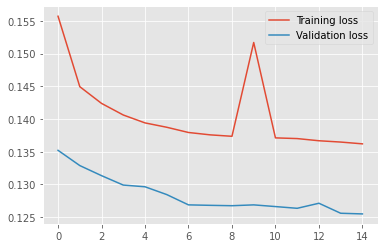

In [26]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

Predict the entire training data

In [27]:
X_glove_TRAIN_predicted = model.predict(X_glove_TRAIN, batch_size=batch_size, verbose=1)
X_glove_TEST_predicted = model.predict(X_glove_TEST, batch_size=batch_size, verbose=1)
X_glove_predicted = model.predict(X_glove, batch_size=batch_size, verbose=1)

1700/1700 [==============================] - 26s 15ms/step


In [29]:
len(X_glove_predicted)

1700

In [31]:
X_glove_predicted[1699]

array([[-2.7716749e-03,  4.0254340e-02, -5.0113756e-02, ...,
        -5.1669423e-03,  4.3555275e-03,  4.6325509e-02],
       [-1.8000973e-03,  3.4984093e-02, -4.1836072e-02, ...,
        -3.4026697e-03,  4.4379579e-03,  3.7394516e-02],
       [-1.0321604e-03,  2.8897284e-02, -3.3604294e-02, ...,
        -1.3713897e-03,  4.5720916e-03,  2.8201817e-02],
       ...,
       [-1.0979348e-03, -1.9629631e-05, -2.8932001e-04, ...,
         3.9739985e-04, -1.2775767e-05, -1.1749903e-03],
       [-1.0206921e-03, -3.2957614e-05, -1.8315128e-04, ...,
         3.8629246e-04, -9.5464173e-05, -1.2454211e-03],
       [-8.6688908e-04, -1.0645189e-04,  7.0579408e-05, ...,
         4.2888141e-04, -2.6487579e-04, -1.4753647e-03]], dtype=float32)

In [32]:
tokens = new_X
# tokens_test = new_X[-256:]
# df_outliers_train = sentence_df[:1440]
# df_outliers_test = sentence_df[-256:]

Predict outliers for train data split

In [33]:
from scipy.spatial.distance import cosine
outliers_all = []
for i in range(len(X_glove_predicted)):
  outliers = []
  for w in range(len(X_glove_predicted[i])):
    cosine_sim_val = (1 - cosine(X_glove[i][w], X_glove_predicted[i][w]))
    if cosine_sim_val < 0.4:
      outliers.append(tokens[i][w])
  outliers_all.append(set(outliers))

In [34]:
len(outliers_all)

1700

In [47]:
outliers_all[10]

{'by',
 'co-founded',
 'commentator',
 'conway',
 'george',
 'gop',
 'lincoln',
 'president',
 'republican',
 'rick',
 'schmidt',
 'steve',
 'strategists',
 'targeting',
 'wilson',
 '―'}

In [36]:
import re
token_length_limit = 4

df_out = pd.DataFrame()
for i in range(len(outliers_all)):
  current_outliers = outliers_all[i]
  current_outliers = list(filter(lambda x: (len(re.sub('\ |\?|\.|\!|\/|\;|\:', '', x)) > token_length_limit), current_outliers))
  df_out = df_out.append(pd.Series([set(current_outliers), tokens[i]]), ignore_index=True)

In [38]:
# outliers
df_out[0]

0                {platform, belated, youtube, conspiracy}
1       {soccer, bitter, american, spilled, jerseys, o...
2                                  {humanitarian, asylum}
3                  {future., teaches, professor, classes}
4                                                {rates.}
                              ...                        
1695    {activists, swarmed, happening., legislators, ...
1696                       {polls, transgender, parents.}
1697    {preside, american, republicans, republican, d...
1698                  {self-described, outspoken, bernie}
1699       {obama, bemoaned, president., colbert, barack}
Name: 0, Length: 1700, dtype: object

In [39]:
# tokens
df_out[1]

0       [youtube, is, making, clear, there, will, be, ...
1       [the, increasingly, bitter, dispute, between, ...
2       [so, while, there, may, be, a, humanitarian, c...
3       [a, professor, who, teaches, climate, change, ...
4       [looking, around, the, united, states,, there,...
                              ...                        
1695    [in, every, case, legislators, are, being, swa...
1696    [polls, show, the, transgender, ideology, is, ...
1697    [democrats, and, republicans, stood, and, appl...
1698    [as, a, self-described, democratic, socialist,...
1699    [during, the, segment,, colbert, also, bemoane...
Name: 1, Length: 1700, dtype: object

In [40]:
sentence_df['outliers'] = df_out[0]
sentence_df['tokenized_sentence'] = df_out[1]

In [42]:
sentence_df = sentence_df.drop(['article'], axis=1)

In [45]:
sentence_df.head(60)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,outliers,tokenized_sentence
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']","{platform, belated, youtube, conspiracy}","[youtube, is, making, clear, there, will, be, ..."
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","{soccer, bitter, american, spilled, jerseys, o...","[the, increasingly, bitter, dispute, between, ..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']","{humanitarian, asylum}","[so, while, there, may, be, a, humanitarian, c..."
3,A professor who teaches climate change classes...,breitbart,environment,right,1,1,Non-biased,No agreement,['legitimate'],"{future., teaches, professor, classes}","[a, professor, who, teaches, climate, change, ..."
4,"Looking around the United States, there is nev...",federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,"['killing', 'never', 'developing', 'humans', '...",{rates.},"[looking, around, the, united, states,, there,..."
5,The World Anti-Doping Agency on Tuesday said t...,reuters,sport,center,1,1,Non-biased,Entirely factual,[],"{anti-doping, russian, tuesday, sanctions, lab...","[the, world, anti-doping, agency, on, tuesday,..."
6,The Republican president assumed he was helpin...,msnbc,environment,left,1,1,Biased,Expresses writer’s opinion,"['rejects', 'happy', 'assumed']","{trade-off, republican, rejects, trump, anyway.}","[the, republican, president, assumed, he, was,..."
7,The explosion of the Hispanic population has l...,breitbart,student-debt,right,1,1,Biased,No agreement,['explosion'],"{explosion, american, aliens, years., hispanic}","[the, explosion, of, the, hispanic, population..."
8,The anti-vaccine movement made headlines last ...,usa-today,vaccines,center,1,1,Biased,Somewhat factual but also opinionated,['distrust'],"{pharmaceutical, measles, distrust, headlines,...","[the, anti-vaccine, movement, made, headlines,..."
9,Thousands of fetal remains that were found at ...,usa-today,abortion,center,1,1,Non-biased,Entirely factual,['abortion'],"{fetal, indiana, suburban, chicago, garage, we...","[thousands, of, fetal, remains, that, were, fo..."


In [44]:
sentence_df.to_csv('outliers_glove_rnn.csv')

Former ESPN personality Jemele Hill attacked the NFL for its lack of black coaches, and blasted the Rooney Rule as an insufficient solution to the problem.


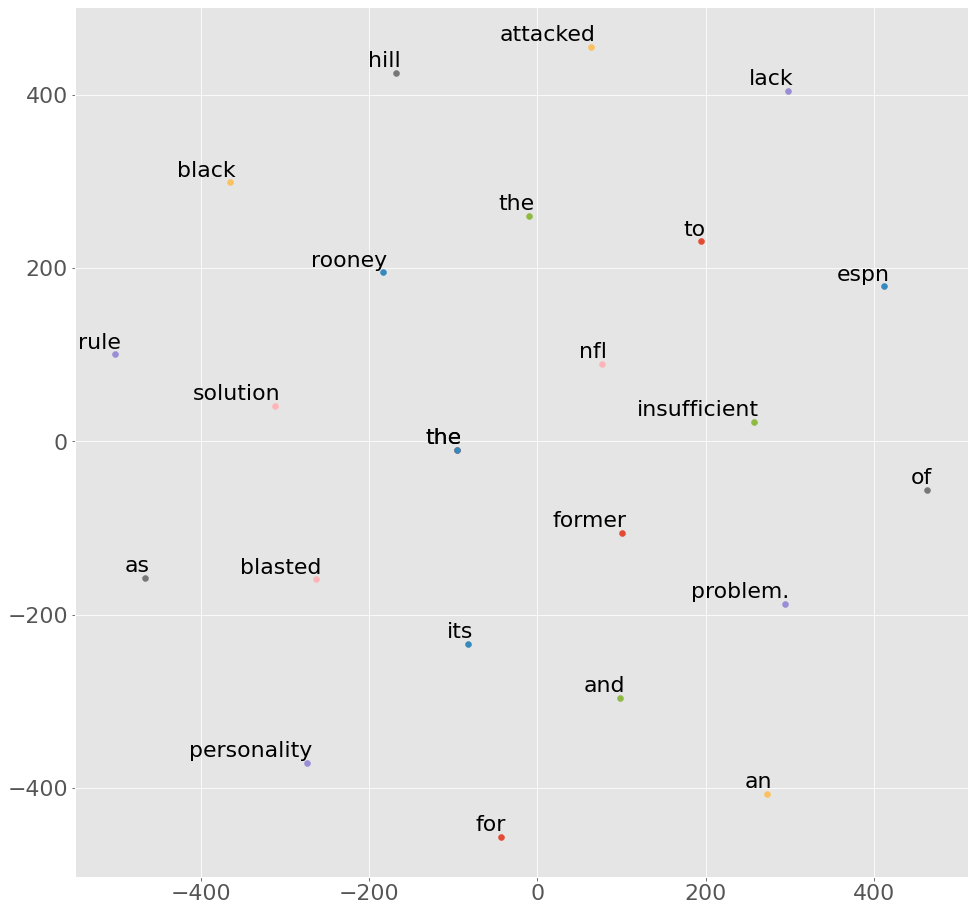

In [ ]:
N = 123

word_embedding_df = to_vectors(sentence_df.tok_sentence[N])

X = word_embedding_df.GloveEmbedding.to_list()
Y = word_embedding_df.Word.to_list()

print(sentence_df.sentence[N])


tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

new_values = tsne_model.fit_transform(X)

x = []
y = []
for value in new_values:
  x.append(value[0])
  y.append(value[1])

plt.figure(figsize=(16, 16)) 
plt.rcParams.update({'font.size': 22})
for i in range(len(x)):
  try:
    plt.scatter(x[i],y[i])
    plt.annotate(Y[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
  except IndexError:
    continue
plt.show()

In [8]:
nlp_sm = spacy.load("en_core_web_sm")
def ne_extractor(text):
  doc = nlp_sm(text)
  norps = []
  persons = []
  for X in doc.ents:
    if X.label_ == 'NORP':
      norps.append(X.text)
    elif X.label_ == 'PERSON':
      persons.append(X.text)
  return norps, persons

In [9]:

ner_tags_df = pd.DataFrame()
sentences_df_temp = sentence_df.sentence
for i in range(len(sentences_df_temp)):
  text = sentences_df_temp[i]
  # check nan
  if text != text:
    continue
  norps, persons = ne_extractor(text)
  ner_tags_df = ner_tags_df.append(pd.Series([norps, persons]), ignore_index=True)
ner_tags_df.columns = ['NORP', 'PERSON']


In [10]:
sentence_df['NORP'] = ner_tags_df.NORP
sentence_df['PERSON'] = ner_tags_df.PERSON

In [11]:
sentence_df.head()

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,NORP,PERSON
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...,[],[]
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput...",[American],[]
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...,[],[]
3,A professor who teaches climate change classes...,breitbart,environment,right,1,1,Non-biased,No agreement,['legitimate'],A professor who teaches climate change classes...,[],[]
4,"Looking around the United States, there is nev...",federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,"['killing', 'never', 'developing', 'humans', '...",The left has a thing for taking babies hostage...,[Democratic],[]


In [12]:
sentences = sentence_df.sentence

In [13]:
X = [[w for w in tokenize_sentence(s)] for s in sentences]

In [14]:
max_len = 50
new_X = []
import re
for seq in X:
  new_seq = []
  for i in range(max_len):
    try:
      new_seq.append(seq[i])
    except:
      new_seq.append("PADDED")
  new_X.append(new_seq)

In [15]:
from numpy import load

embs_split_0_0to200 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_0_until200.npy')
embs_split_0_201to425 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_0_201to425.npy')
embs_split_1 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_1.npy')
embs_split_2_0to298 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_2_until298.npy')
embs_split_2_299to425 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_2_299to425.npy')
embs_split_3 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_3.npy')

In [ ]:
embs_split_2_299to425[:127]

In [16]:
sentence_elmo_embeddings = np.concatenate((embs_split_0_0to200[:200], embs_split_0_201to425[:225], embs_split_1, embs_split_2_0to298[:298], embs_split_2_299to425[:127], embs_split_3), axis=0)

In [17]:
sentence_elmo_embeddings.shape

(1700, 50, 1024)

In [18]:
sentence_df['tok_sentence'] = np.zeros(shape=(1700, 1))
for i in range(len(sentence_df)):
  sentence_df['tok_sentence'][i] = tokenize_sentence(sentence_df.sentence[i])

In [19]:
print(sentence_df.tok_sentence[0])

['youtube', 'is', 'making', 'clear', 'there', 'will', 'be', 'no', '“birtherism”', 'on', 'its', 'platform', 'during', 'this', 'year’s', 'u.s.', 'presidential', 'election', '–', 'a', 'belated', 'response', 'to', 'a', 'type', 'of', 'conspiracy', 'theory', 'more', 'prevalent', 'in', 'the', '2012', 'race.']


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


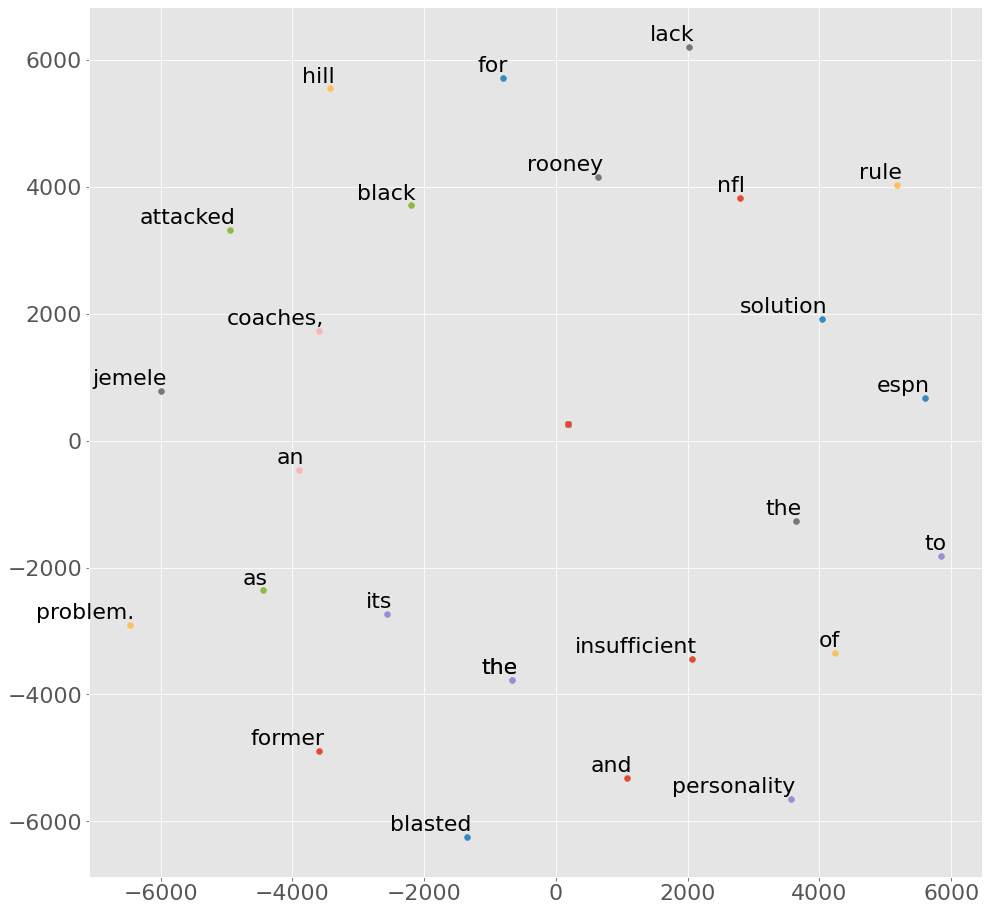

In [ ]:
N = 123
X = sentence_elmo_embeddings[N]
Y = sentence_df.tok_sentence[N]

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

new_values = tsne_model.fit_transform(X)

x = []
y = []
for value in new_values:
  x.append(value[0])
  y.append(value[1])

plt.figure(figsize=(16, 16)) 
plt.rcParams.update({'font.size': 22})
for i in range(len(x)):
  try:
    plt.scatter(x[i],y[i])
    plt.annotate(Y[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
  except IndexError:
    continue
plt.show()